In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

notes = pd.read_csv('data/processed_notes.csv')
notes

,case_num,processed_notes,initial_note_length,processed_note_length
0,0,year old male come student health clinic compl...,695,563
1,0,year old male recurrent palpitation past month...,424,305
2,0,dillon cleveland year old male patient signifi...,835,571
3,0,year old male complains palpitation started mo...,700,540
4,0,year old male past medical history evaluation ...,948,673
...,...,...,...,...
42141,9,m madden year old female presenting w worst ha...,765,545
42142,9,year old female came complain dull headache as...,634,504
42143,9,m madden year old female present headache day ...,928,661
42144,9,stephanie madden year old woman complaining he...,697,558


### Notes:

- We know that there are 10 patients and 42146 documents. These 10 patients themselves might be clusters. 

- So, remove the 'case_num' column to make the problem completely Unsupervised learning.

- Will have to consider the inclusion of processed_note_length and initial_note_length later.

In [8]:
# setting X and y for modelling

X = notes[['processed_notes', 'initial_note_length', 'processed_note_length']]
y = notes['case_num']
 


# Initialize the vectorizer with 1-grams and other hyperparameters as needed
# Since the preprocessing is already done, we don't need to specify a custom tokenizer or stop words
vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                             min_df = 0.001, 
                             max_df = 0.9)

# Fit and transform th e preprocessed 'pn_history' column to create the DTM
dtm = vectorizer.fit_transform(X['processed_notes'])
dtm_dense = dtm.todense()

# Convert DTM to a DataFrame
dtm_df = pd.DataFrame(dtm_dense, columns=vectorizer.get_feature_names_out())



# Describe the DTM
print("Size of the DTM: ", dtm_df.shape) 
memory_usage = dtm_df.memory_usage(deep=True).sum()
print("Memory usage (in bytes): ", memory_usage)
dtm_df

Size of the DTM:  (42146, 2478)
Memory usage (in bytes):  835502432


,aa,aaf,ab,abd,abdo,abdomen,abdominal,ability,able,abnormal,...,yellow,yellowing,yesterday,yet,yof,yom,young,younger,youngest,yr
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.182849,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.090843,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,0.0,0.0,0.0,0.137661,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.191541,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42142,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42143,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.082982,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42144,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.097239,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Notes:

- As predicted in the EDA, the words like year, past, history cannot be found in the Document Term Matrix.



In [9]:
def cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, save_name):

    sns.set(style="darkgrid")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot the inertia values
    axes[0].plot(range(min_cluster,max_cluster+1), inertia_values, marker='o') 
    axes[0].set_title('Inertia')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Inertia')  


    # Plot the silhouette scores
    axes[1].plot(range(min_cluster,max_cluster+1), silhouette_scores, marker='o') 
    axes[1].set_title('Silhouette Score') 
    axes[1].set_xlabel('Number of clusters') 
    axes[1].set_ylabel('Silhouette Score')
    plt.savefig(save_name)
    plt.show()



In [10]:
min_cluster = 3
max_cluster = 14

## Dimensionality Reduction

### i. Using TruncatedSVD

In [11]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=2)
X_lsa = lsa.fit_transform(dtm)

explained_variance = lsa.explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


Explained variance of the SVD step: 3.9%


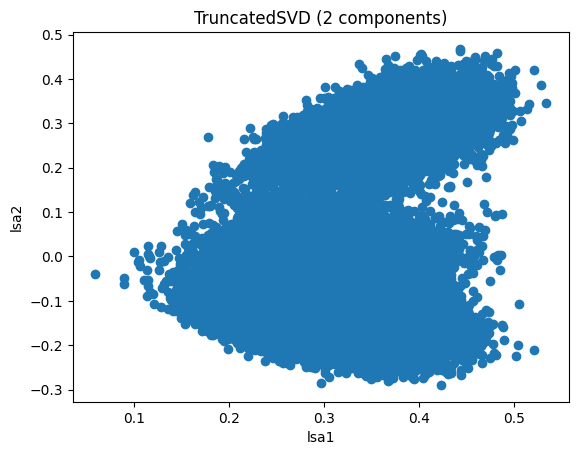

In [12]:
lsa_df = pd.DataFrame(data = X_lsa, columns = ['lsa1', 'lsa2'])

plt.scatter(lsa_df['lsa1'],lsa_df['lsa2'])
plt.xlabel('lsa1')
plt.ylabel('lsa2')
plt.title('TruncatedSVD (2 components)')
plt.savefig('figs/2_component_lsa.png')
plt.show()

### Notes:

- The 2 components have a cumulative explained variance score of 3.9% only.

- This means that we lost 96% of the original variance. 

- Lets see how the k-means clustering goes.

Explained variance of the SVD step: 83.6%
Number elements in 3 clusters: [ 9415 22988  9743]
Number elements in 4 clusters: [ 5362 22856  9743  4185]
Number elements in 5 clusters: [ 5390 13673  9750  4189  9144]
Number elements in 6 clusters: [ 5390 12056  1594  4190  9159  9757]
Number elements in 7 clusters: [ 5392 12076  1594  4190  2271  9756  6867]
Number elements in 8 clusters: [2060 2269 4187 7426 9764 6867 3390 6183]
Number elements in 9 clusters: [2060  809 4187 6747 9750 6867 3391 6065 2270]
Number elements in 10 clusters: [2059  809 4187 6747 6548 6867 3391 6065 2269 3204]
Number elements in 11 clusters: [2058  809 4187 5151 6561 6867 3391 6065 2268 3194 1595]
Number elements in 12 clusters: [2042  809 4188 5151 6561 4469 3381 6059 2262 3194 1595 2435]
Number elements in 13 clusters: [2031  809 4188 5148 6550 1991 3381 6049 2258 3204 1595 2554 2388]
Number elements in 14 clusters: [2033  809 4188 1901 6560 1994 3379 6049 2258 3194 1596 2548 2388 3249]


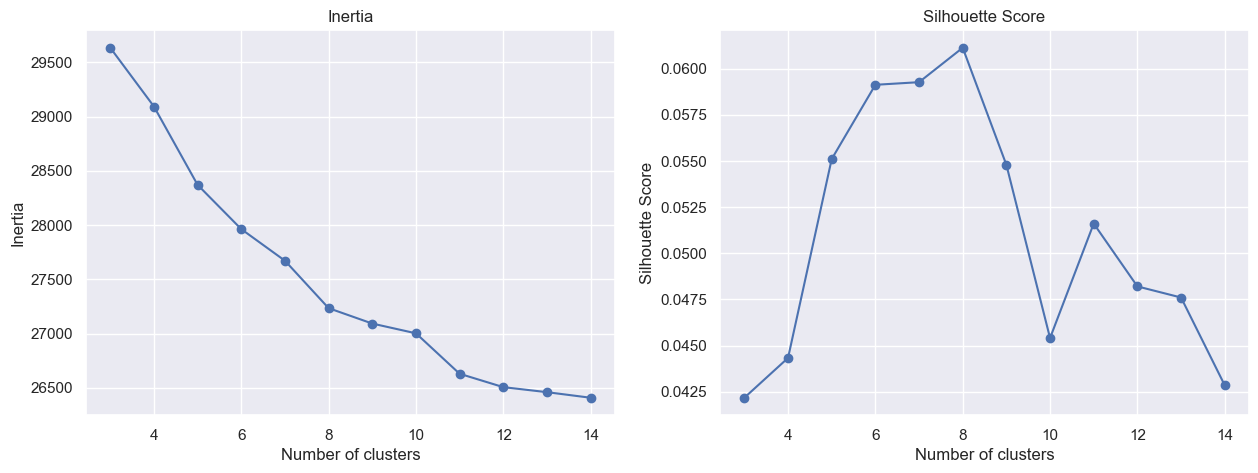

Best silhouette score for TruncatedSVD 1000 components: 0.061133582443833226
- Best silhouette score is observed at n_clusters = 8
- n_clusters account to Inertia scores are: 27234.512164722888


In [13]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=1000)
X_lsa = lsa.fit_transform(dtm)
explained_variance = lsa.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_lsa, kmeans.labels_))


cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/lsa_kmeans_scores.png')

print('Best silhouette score for TruncatedSVD 1000 components:', max(silhouette_scores))
print(f'- Best silhouette score is observed at n_clusters = {min_cluster + silhouette_scores.index(max(silhouette_scores))}')

print(f'- n_clusters account to Inertia scores are:', inertia_values.index(KneeLocator(inertia_values, list(range(min_cluster, max_cluster+1)), curve='convex', direction='decreasing').knee))


### ii. Using UMAP

/Users/saideepbunny/anaconda3/envs/nlp_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,umap_1,umap_2
0,21.255512,8.733173
1,21.893475,8.232828
2,21.240074,8.010957
3,20.512318,8.023854
4,21.832140,8.100152
...,...,...
42141,2.351455,4.274601
42142,2.457645,6.064574
42143,1.447634,4.983854
42144,1.454219,4.879840


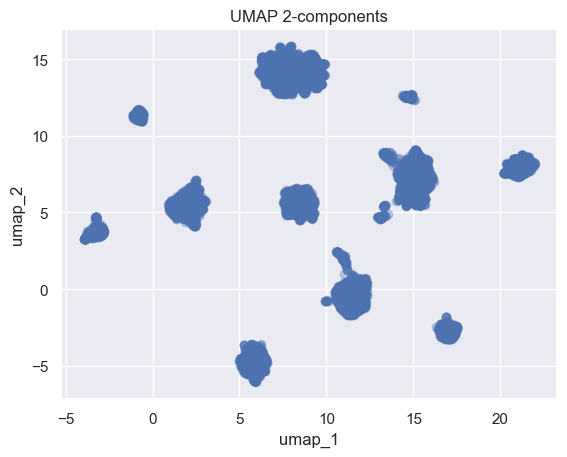

In [52]:
reducer = umap.UMAP(n_neighbors = 5, n_components = 2, metric = 'euclidean', min_dist = 0.05, spread = 1.0, random_state=42)
projected_data = reducer.fit_transform(dtm)

red1 = pd.DataFrame(data=projected_data, columns=['umap_1','umap_2'])
display(red1)

plt.scatter(red1['umap_1'],red1['umap_2'], alpha = 0.3)
plt.title('UMAP 2-components')
plt.xlabel('umap_1')
plt.ylabel('umap_2')
plt.savefig('figs/umap_2_component.png')
plt.show()

- When UMAP is used for dimensionality reduction (2 components), those components have formed 11 noticable clusters.



#### UMAP K-means

Number elements in 3 clusters: [20296 10478 11372]
Number elements in 4 clusters: [11520  9679  9413 11534]
Number elements in 5 clusters: [ 7343  9679  9413 11534  4177]
Number elements in 6 clusters: [ 7343  9679  2228  7479  4177 11240]
Number elements in 7 clusters: [7318 9679 2228 7479 4177 4080 7185]
Number elements in 8 clusters: [5384 9679 7479 7185 1959 4055 2228 4177]
Number elements in 9 clusters: [5384 9679 5885 7185 1959 4055 2228 4177 1594]
Number elements in 10 clusters: [5384 9679 5086 7185 1959 4055 2228 4177 1594  799]
Number elements in 11 clusters: [5384 6001 5086 7185 1959 4055 2228 4177 1594  799 3678]
Number elements in 12 clusters: [5384 6001 5086 6880 1959 4055 2228 4177 1594  799 3678  305]
Number elements in 13 clusters: [5384 6001 5086 3975 1959 4055 2228 4177 1594  799 3678  305 2905]
Number elements in 14 clusters: [5384 6001 1982 3975 1959 4055 2228 4177 1594  799 3678  305 2905 3104]


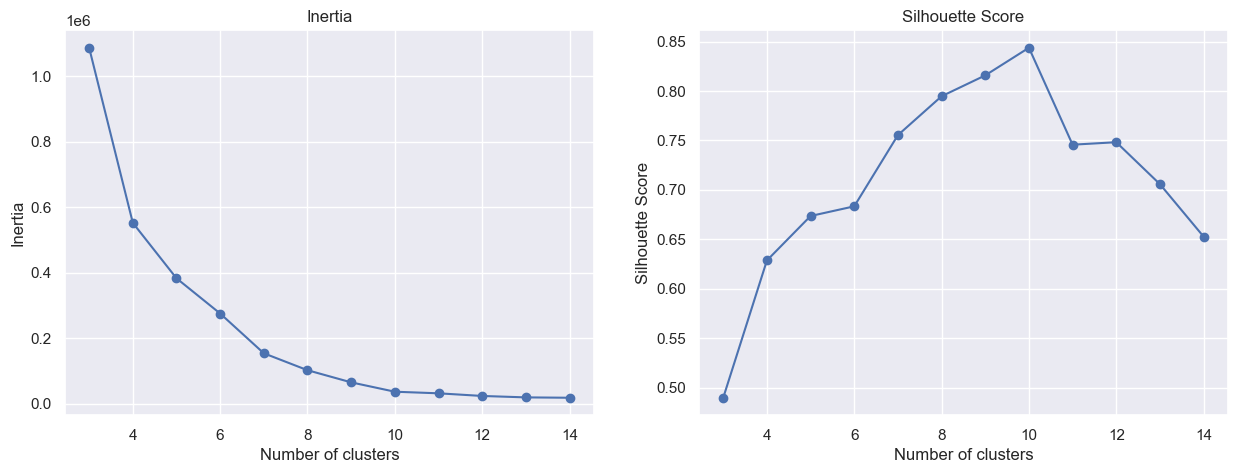

Best silhouette score for UMAP 2 components: 0.8437744
- Best silhouette score is observed at n_clusters = 10
- n_clusters account to Inertia scores are: 4


In [53]:
inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(projected_data)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(projected_data, kmeans.labels_))

cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/umap_kmeans_scores.png')

print('Best silhouette score for UMAP 2 components:', max(silhouette_scores))
print(f'- Best silhouette score is observed at n_clusters = {min_cluster + silhouette_scores.index(max(silhouette_scores))}')

print(f'- n_clusters account to Inertia scores are:', inertia_values.index(KneeLocator(inertia_values, list(range(min_cluster, max_cluster+1)), curve='convex', direction='decreasing').knee))


- The inertia scores don't show a clear elbow to decide number of clusters.

- The silhouette scores indicate that the number of clusters = 10.

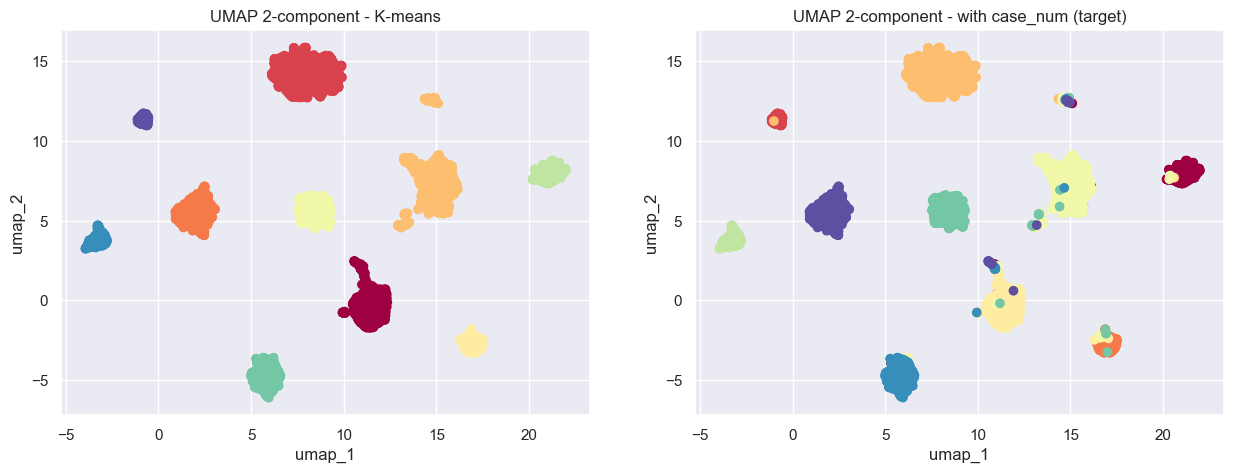

In [54]:
#plotting for kmeans 10 clusters and Checking against the target- case_num

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(projected_data)

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(red1['umap_1'],red1['umap_2'], c=kmeans.labels_, cmap='Spectral')
axes[0].set_title('UMAP 2-component - K-means')
axes[0].set_xlabel('umap_1')
axes[0].set_ylabel('umap_2')


axes[1].scatter(red1['umap_1'],red1['umap_2'], c=y, cmap='Spectral')
axes[1].set_title('UMAP 2-component - with case_num (target)')
axes[1].set_xlabel('umap_1')
axes[1].set_ylabel('umap_2')

plt.savefig('figs/umap_kmeans_casenum.png')
plt.show()

In [55]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

mapping = {6: 0, 
           9: 1, 
           4: 2, 
           1: 3, 
           0: 4, 
           3: 5, 
           8: 6, 
           5: 7, 
           7: 8, 
           2: 9}

relabeled_labels = np.vectorize(mapping.get)(kmeans.labels_)
print('Adjusted rand score for the Kmeans clustering solution:',adjusted_rand_score(y, relabeled_labels))
print('Contingency matrix:')
contingency_matrix(y, relabeled_labels)


Adjusted rand score for the Kmeans clustering solution: 0.9769278244415002
Contingency matrix:


array([[2223,    0,    0,    1,    3,   40,    0,    0,    1,    0],
       [   0,  798,    0,    1,    1,    7,    0,    1,    0,    0],
       [   0,    0, 1948,    0,    1,    4,    0,    5,    0,    0],
       [   1,    1,    0, 9677,    2,   71,    0,    1,    0,    0],
       [   1,    0,    6,    0, 5312,   78,    0,    3,    4,    1],
       [   3,    0,    1,    0,   14, 6884,    0,    4,    1,    2],
       [   0,    0,    0,    0,    0,    2, 1594,    0,    0,    1],
       [   0,    0,    4,    0,    1,   55,    0, 4041,    0,    0],
       [   0,    0,    0,    0,   19,    6,    0,    0, 4171,    0],
       [   0,    0,    0,    0,   31,   38,    0,    0,    0, 5082]])

- We can see that there is overlap in patient case_num from the clusters formed.

- Considering the context of patient notes, this overlap might be due to the similar symptoms.

#### UMAP HDBSCAN

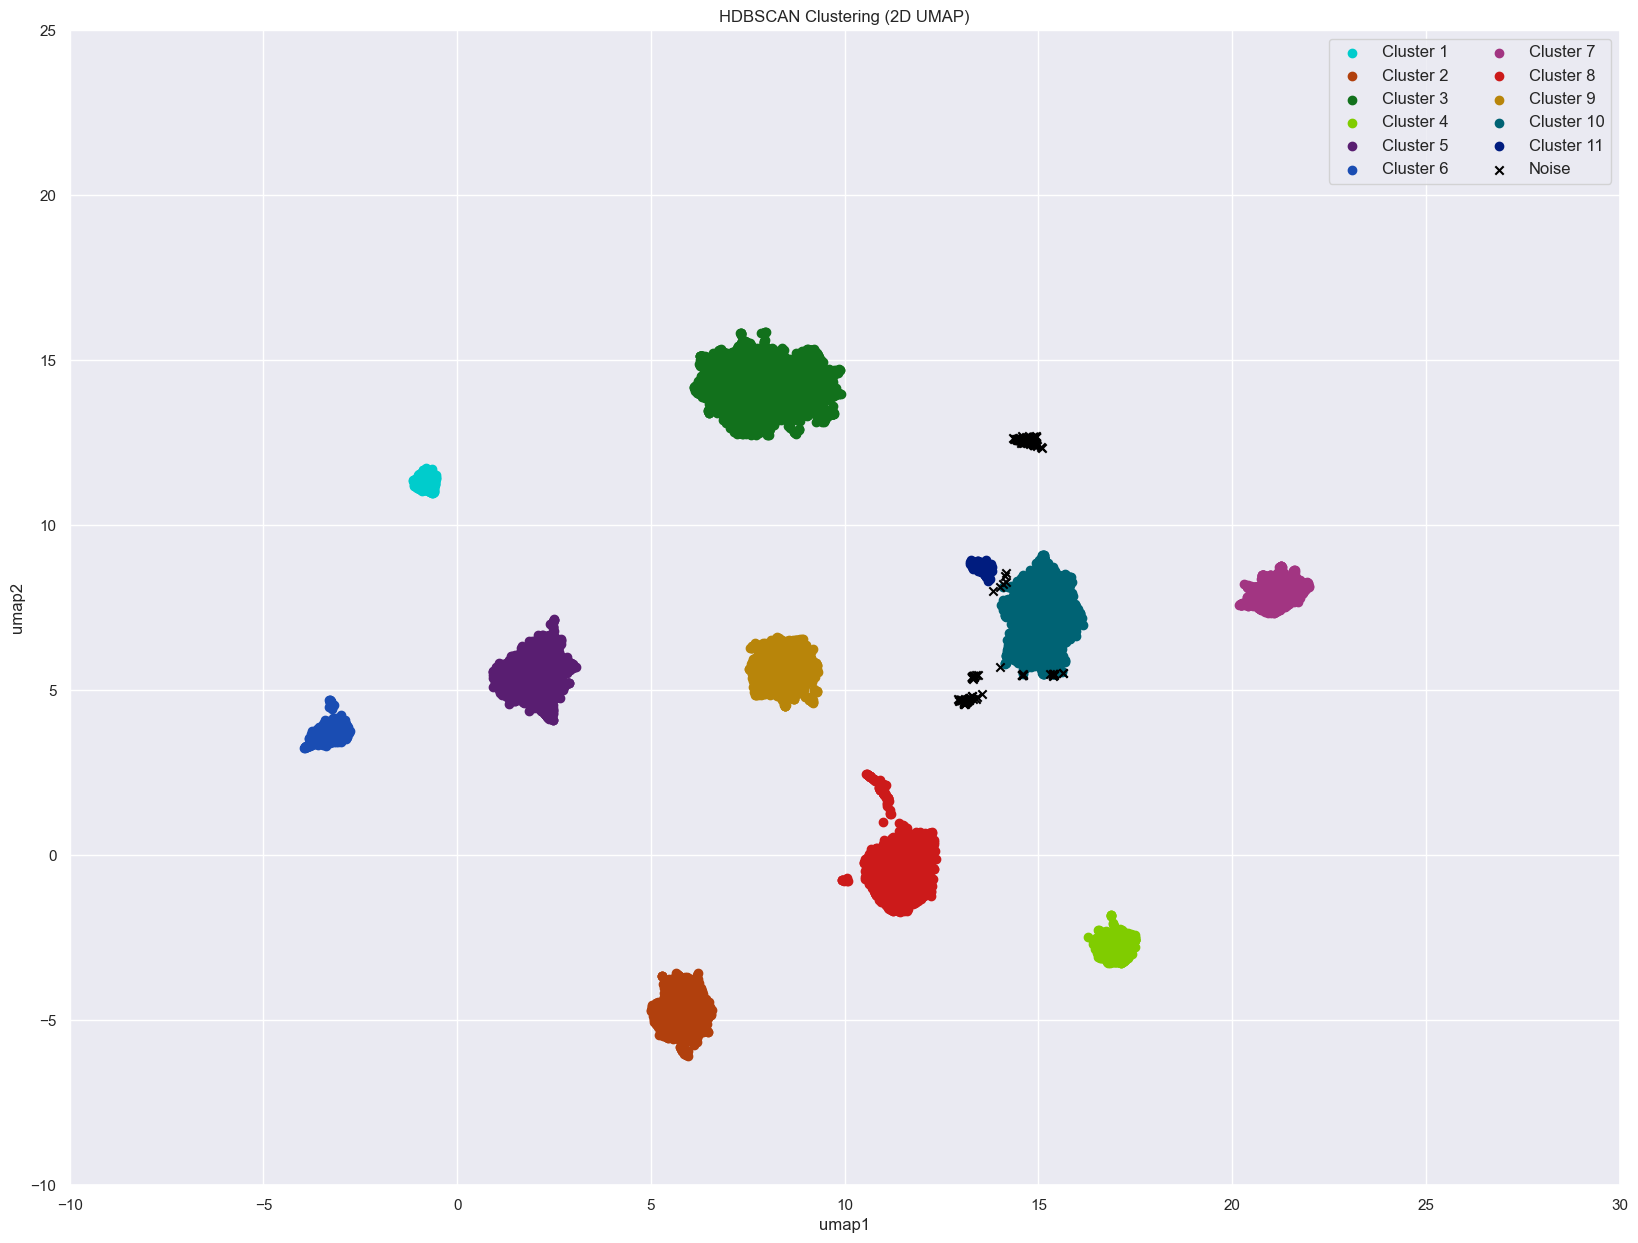

In [56]:
from sklearn.cluster import HDBSCAN
import seaborn as sns

hdb_tsne = HDBSCAN(min_cluster_size=500, min_samples = 100)
cluster_labels = hdb_tsne.fit_predict(red1)

plt.figure(figsize = (20,15))

palette = sns.color_palette('dark', np.unique(cluster_labels).max() + 1)
palette[7] = (0.8, 0.1, 0.1)
palette[5] = (0.1, 0.3, 0.7)
palette[3] = (0.5, 0.8, 0)
palette[0] = (0, 0.8, 0.8)

#plotting clusters
for i in range(np.unique(cluster_labels).max() + 1):
    plt.scatter(red1[cluster_labels == i]['umap_1'], red1[cluster_labels == i]['umap_2'], color = palette[i], label = f'Cluster {i+1}')

#plotting noise
plt.scatter(red1[cluster_labels == -1]['umap_1'], red1[cluster_labels == -1]['umap_2'], color = 'black', marker = 'x', label = f'Noise')


plt.title('HDBSCAN Clustering (2D UMAP)')
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.xlim(-10, 30)
plt.ylim(-10, 25)
plt.legend(loc = 'best', fontsize = 'medium', ncols =2)
plt.savefig('figs/hdbscan_clusters.png')
plt.show()

In [65]:
clustering_df = pd.DataFrame()
clustering_df['y'] = y
clustering_df['y_pred'] = cluster_labels
no_noise = clustering_df[clustering_df['y_pred'] != -1]

mapping = {6: 0, 
           0: 1, 
           3: 2, 
           2: 3, 
           7: 4, 
           9: 5, 
           5: 6, 
           8: 7, 
           1: 8, 
           4: 9,
          10:10}

no_noise['y_pred'] = no_noise['y_pred'].replace(mapping)


print('Adjusted rand score for the DBSCAN clustering solution:',adjusted_rand_score(no_noise['y'], no_noise['y_pred']))
print('Contingency matrix:')
contingency_matrix(no_noise['y'], no_noise['y_pred'])


Adjusted rand score for the DBSCAN clustering solution: 0.977770219541886
Contingency matrix:


/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_74439/3797852457.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_noise['y_pred'] = no_noise['y_pred'].replace(mapping)


array([[2223,    0,    0,    1,    3,    5,    0,    0,    1,    0,    0],
       [   0,  798,    0,    1,    1,    0,    0,    1,    0,    0,    0],
       [   0,    0, 1948,    0,    1,    0,    0,    5,    0,    0,    0],
       [   1,    1,    0, 9677,    2,    0,    0,    1,    0,    0,    0],
       [   1,    0,    6,    0, 5312,   11,    0,    3,    4,    1,    0],
       [   3,    0,    1,    0,   14, 6200,    0,    4,    1,    2,  520],
       [   0,    0,    0,    0,    0,    0, 1594,    0,    0,    1,    0],
       [   0,    0,    4,    0,    1,    2,    0, 4041,    0,    0,    0],
       [   0,    0,    0,    0,   19,    1,    0,    0, 4171,    0,    0],
       [   0,    0,    0,    0,   31,    0,    0,    0,    0, 5082,    0]])

### Using T-SNE

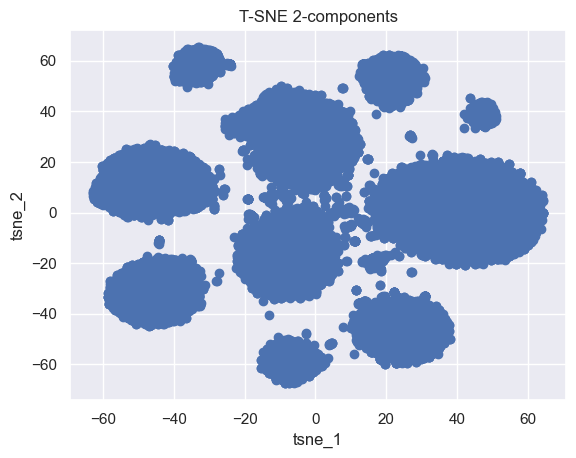

In [66]:
tsne = TSNE(n_components=2,  random_state = 42, init='random')
tsne_result = tsne.fit_transform(dtm)
red2 = pd.DataFrame(data=tsne_result, columns=['tsne1','tsne2'])
red2


plt.scatter(red2['tsne1'],red2['tsne2'])
plt.title('T-SNE 2-components')
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')
plt.savefig('figs/tsne_2components.png')
plt.show()

#### T-SNE KMeans

Number elements in 3 clusters: [16486 11403 14257]
Number elements in 4 clusters: [10312 10627 10582 10625]
Number elements in 5 clusters: [ 9430 10590 10639  6385  5102]
Number elements in 6 clusters: [ 6076 10391 10390  6022  5082  4185]
Number elements in 7 clusters: [ 6039 10366  6007  6019  5082  4185  4448]
Number elements in 8 clusters: [ 6020 10366  5984  5082  1963  4078  4468  4185]
Number elements in 9 clusters: [5643 8131 6262 5082 1963 4082 3756 4185 3042]
Number elements in 10 clusters: [6714 1593 5913 5082 1963 4081 3932 4185 3041 5642]
Number elements in 11 clusters: [2071 6447 5505 5082 1963 4077 4132 4185 3041 4050 1593]
Number elements in 12 clusters: [2477 3312 5334 5082 1963 4057 4285 4185 3037 3376 1593 3445]
Number elements in 13 clusters: [2445 2323 5467 5082 1963 4057 4160 4185 3037 3391 1593 2890 1553]
Number elements in 14 clusters: [2445 2323 5467 5082 1963 4057 4160 2266 3037 3391 1593 2890 1553 1919]


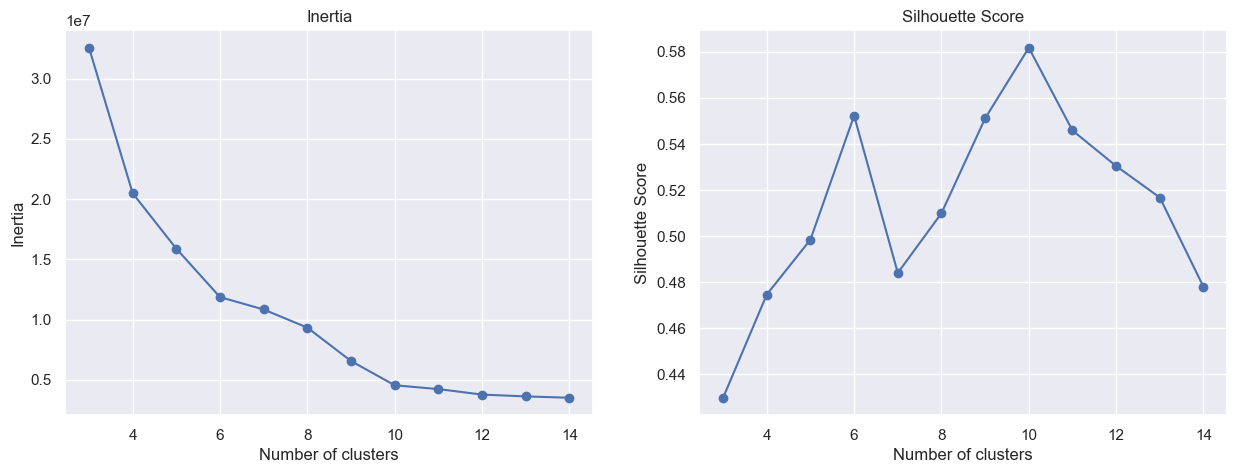

Best silhouette score for T-SNE 2 components: 0.58179814
- Best silhouette score is observed at n_clusters = 10
- n_clusters account to Inertia scores are: 3


In [67]:
inertia_values = []
silhouette_scores = []

for num_clust in range(min_cluster,max_cluster+1):
    kmeans = KMeans(n_clusters=num_clust, random_state=42, n_init='auto').fit(tsne_result)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number elements in {num_clust} clusters: {cluster_sizes}")
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tsne_result, kmeans.labels_))

cluster_score_plots(min_cluster, max_cluster, inertia_values, silhouette_scores, 'figs/tsne_kmeans_scores.png')

print('Best silhouette score for T-SNE 2 components:', max(silhouette_scores))
print(f'- Best silhouette score is observed at n_clusters = {min_cluster + silhouette_scores.index(max(silhouette_scores))}')

print(f'- n_clusters account to Inertia scores are:', inertia_values.index(KneeLocator(inertia_values, list(range(min_cluster, max_cluster+1)), curve='convex', direction='decreasing').knee))

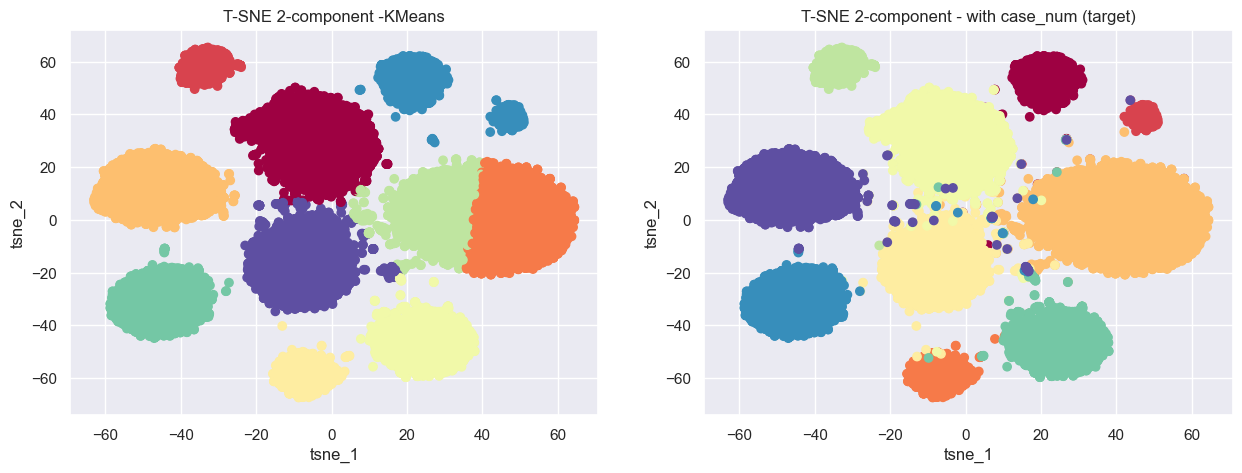

In [68]:
#plotting for kmeans 10 clusters and Checking against the target- case_num

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(tsne_result)

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(red2['tsne1'],red2['tsne2'], c=kmeans.labels_, cmap='Spectral')
axes[0].set_title('T-SNE 2-component -KMeans')
axes[0].set_xlabel('tsne_1')
axes[0].set_ylabel('tsne_2')


axes[1].scatter(red2['tsne1'],red2['tsne2'], c=y, cmap='Spectral')
axes[1].set_title('T-SNE 2-component - with case_num (target)')
axes[1].set_xlabel('tsne_1')
axes[1].set_ylabel('tsne_2')
plt.savefig('figs/tnse_kmeans_casenum.png')
plt.show()

In [69]:
'''mapping = {6: 0, 
           9: 1, 
           4: 2, 
           1: 3, 
           0: 4, 
           3: 5, 
           8: 6, 
           5: 7, 
           7: 8, 
           2: 9}

relabeled_labels = np.vectorize(mapping.get)(kmeans.labels_)'''
print('Adjusted rand score for the Kmeans clustering solution:',adjusted_rand_score(y, kmeans.labels_))
print('Contingency matrix:')
contingency_matrix(y, kmeans.labels_)


Adjusted rand score for the Kmeans clustering solution: 0.8491165646794702
Contingency matrix:


array([[  10,    0,    1,    0,    0,    0,   11,    0, 2217,   29],
       [   2,    0,    0,    0,    0,    0,    4,    0,  796,    6],
       [   0,    0,    0,    0, 1950,    3,    0,    0,    0,    5],
       [   3,    0, 5912,    0,    0,    1, 3809,    0,    9,   19],
       [  10,    0,    0,    2,    4,    1,   28,    3,    1, 5356],
       [6683,    0,    0,    3,    1,    4,   60,    2,    9,  147],
       [   0, 1593,    0,    0,    0,    0,    0,    0,    0,    4],
       [   1,    0,    0,    0,    8, 4072,    3,    0,    7,   10],
       [   0,    0,    0,    0,    0,    0,   12, 4174,    0,   10],
       [   5,    0,    0, 5077,    0,    0,    5,    6,    2,   56]])

#### T-SNE HDBSCAN

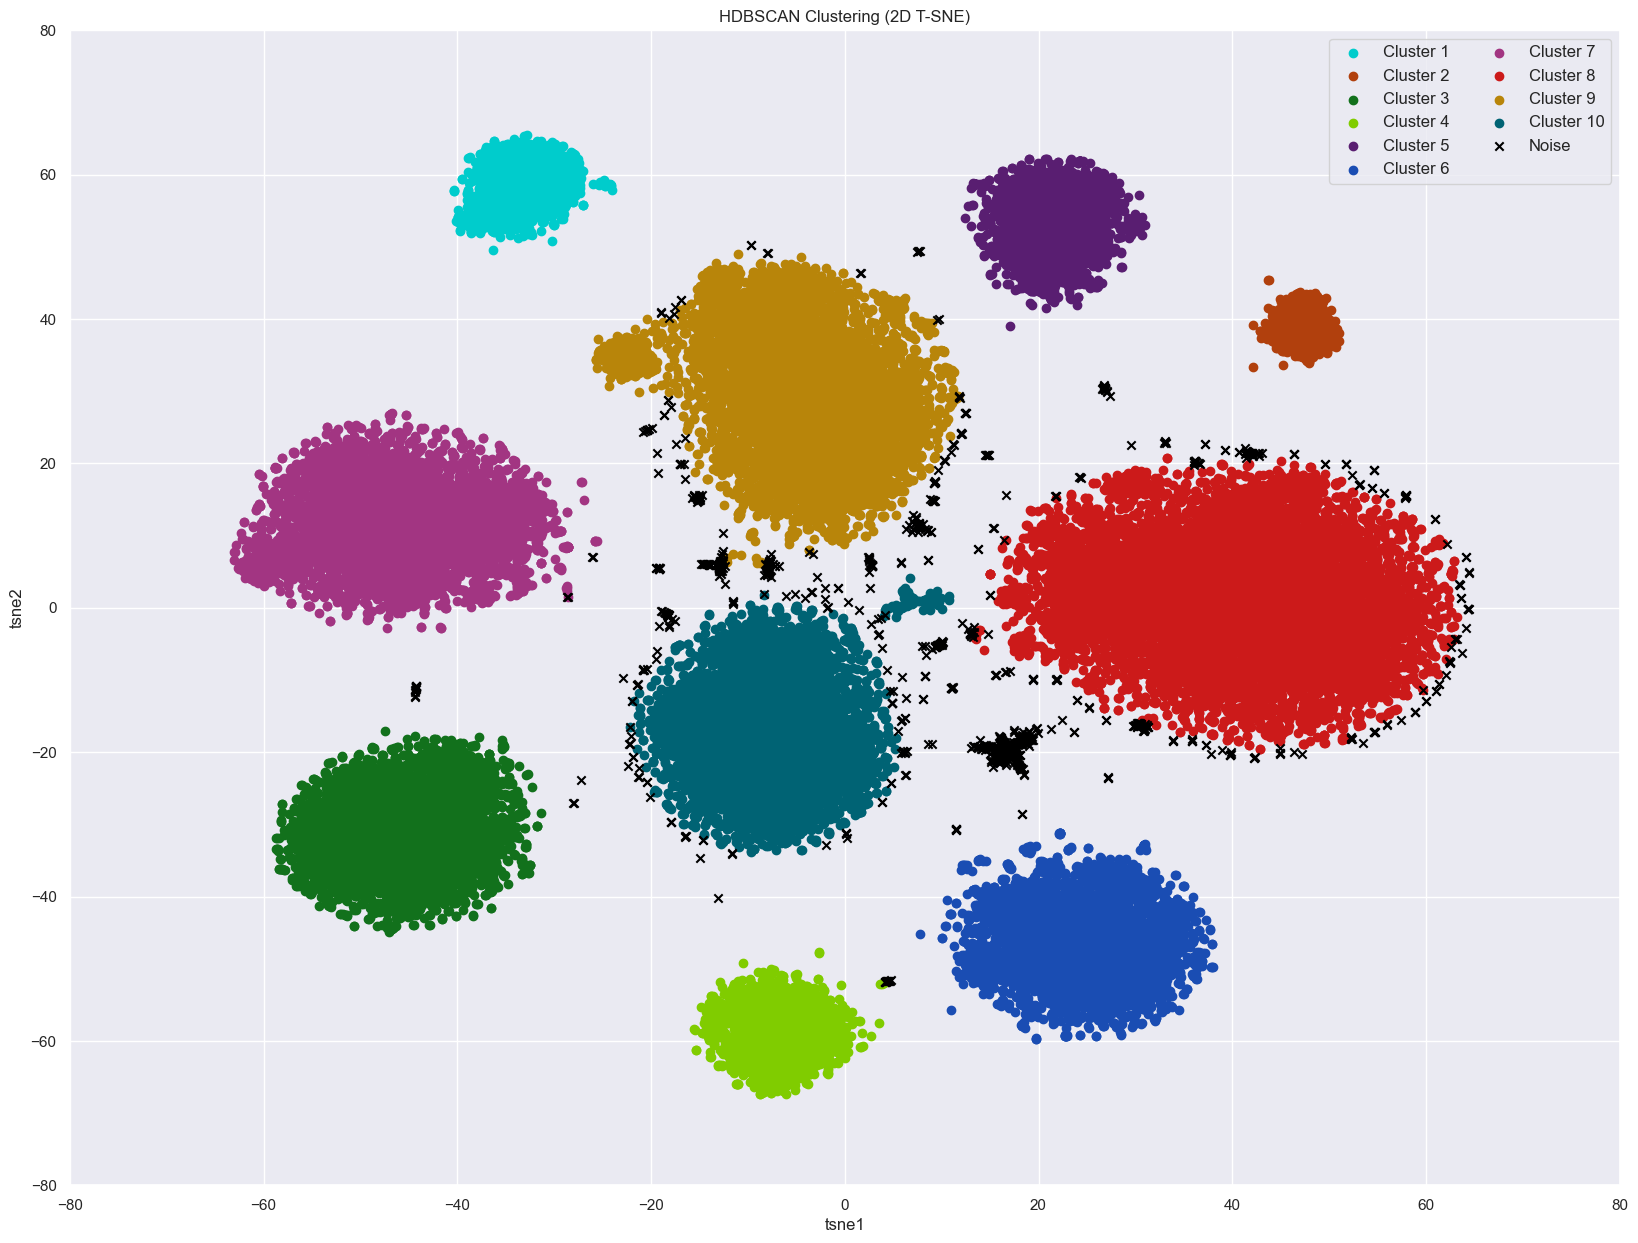

In [70]:
from sklearn.cluster import HDBSCAN
import seaborn as sns

hdb_tsne = HDBSCAN(min_cluster_size=500, min_samples = 100)
cluster_labels = hdb_tsne.fit_predict(red2)

plt.figure(figsize = (20,15))

palette = sns.color_palette('dark', np.unique(cluster_labels).max() + 1)
palette[7] = (0.8, 0.1, 0.1)
palette[5] = (0.1, 0.3, 0.7)
palette[3] = (0.5, 0.8, 0)
palette[0] = (0, 0.8, 0.8)

#plotting clusters
for i in range(np.unique(cluster_labels).max() + 1):
    plt.scatter(red2[cluster_labels == i]['tsne1'], red2[cluster_labels == i]['tsne2'], color = palette[i], label = f'Cluster {i+1}')

#plotting noise
plt.scatter(red2[cluster_labels == -1]['tsne1'], red2[cluster_labels == -1]['tsne2'], color = 'black', marker = 'x', label = f'Noise')


plt.title('HDBSCAN Clustering (2D T-SNE)')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(loc = 'best', fontsize = 'medium', ncols =2)
plt.savefig('figs/hdbscan_clusters.png')
plt.show()

In [72]:
clustering_df = pd.DataFrame()
clustering_df['y'] = y
clustering_df['y_pred'] = cluster_labels
no_noise = clustering_df[clustering_df['y_pred'] != -1]

mapping = {4: 0, 
           1: 1, 
           3: 2, 
           7: 3, 
           9: 4, 
           8: 5, 
           0: 6, 
           5: 7, 
           2: 8, 
           6: 9}

no_noise['y_pred'] = no_noise['y_pred'].replace(mapping)


print('Adjusted rand score for the DBSCAN clustering solution:',adjusted_rand_score(no_noise['y'], no_noise['y_pred']))
print('Contingency matrix:')
contingency_matrix(no_noise['y'], no_noise['y_pred'])

Adjusted rand score for the DBSCAN clustering solution: 0.9910386197500075
Contingency matrix:


/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_74439/1782881914.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_noise['y_pred'] = no_noise['y_pred'].replace(mapping)


array([[2210,    0,    0,    3,    3,    7,    0,    0,    0,    0],
       [   0,  793,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0, 1946,    0,    1,    0,    0,    3,    0,    0],
       [   0,    1,    0, 9343,   61,    0,    0,    0,    0,    0],
       [   0,    0,    3,    0, 5144,    8,    0,    0,    1,    1],
       [   0,    0,    1,    1,   25, 6568,    0,    2,    1,    3],
       [   0,    0,    0,    0,    0,    0, 1593,    0,    0,    0],
       [   0,    0,    1,    0,    1,    1,    0, 4045,    0,    0],
       [   0,    0,    0,    1,    9,    0,    0,    0, 4168,    0],
       [   0,    1,    0,    0,    6,    2,    0,    0,    0, 5074]])